In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

In [2]:
import io, zipfile,os
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irfanfadhullah","key":"1ff88748b498312e668d02a61cf44260"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d alessiocorrado99/animals10

 98% 576M/586M [00:17<00:00, 27.7MB/s]
100% 586M/586M [00:17<00:00, 35.8MB/s]


Alasan memilih dataset ini adalah agar memenuhi kriteria Bintang 5 Dicoding, yaitu resolusi yang beragam, lebih dari 3 class

In [6]:
zip_ref = zipfile.ZipFile("/content/animals10.zip", 'r') #file yang ingin di ekstrak
zip_ref.extractall("/content") #ekstrack dataset ke folder temp di google collab
zip_ref.close()

In [7]:
train_path='/content/raw-img/'

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale=1./255,
                                   shear_range=0.2,
                                   samplewise_center = True,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = .2
)
traindata= train_path
validationdata = train_path
batch_size = 128

#img_height=150
#img_width= 150

train_gen = train_datagen.flow_from_directory( 
    directory=train_path,
    batch_size=batch_size,
    shuffle=True,
    target_size=(150,150),
    class_mode='categorical',
    subset='training'
    )
validation_gen = train_datagen.flow_from_directory(
    directory=train_path,
    batch_size=batch_size,
    shuffle=True,
    target_size=(150,150),
    class_mode='categorical',
    subset='validation'
    )


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [9]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import VGG19


Alasan memakai PreTrained Model adalah saat menggunakan model buatan sendiri tidak mencapai accuracy yang maksimal, sekitar 70%

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.92)&(logs.get('accuracy')>0.92):
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [11]:
checkpoint_path = "/content/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Buat Callback untuk save weight model, jaga2 kalau connectionloss
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2)


In [26]:
#Membuat fungsi menurunkan Learning Rate saat berada di Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                 factor = 0.2, 
                                                 patience = 2, 
                                                 verbose = 1, 
                                                 min_delta=0.001, 
                                                 min_lr = 1e-10)

In [21]:
model = tf.keras.Sequential([
                                     VGG19(weights="imagenet", include_top=False, input_shape=(150,150, 3)),
                                     #tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Dropout(0.2),
                                     #tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(256,activation='relu'),
                                     tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(128,activation='relu'),
                                     tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(10,activation='softmax')
])
model.layers[0].trainable = True
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         589952    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

In [16]:
#steps = compute_steps_per_epoch(train_gen.n)
#val_steps = compute_steps_per_epoch(validation_gen.n)

In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_gen,
                    steps_per_epoch=train_gen.n//train_gen.batch_size + 1,  # banyaknya step yang dieksekusi dalam setiap epoch yang dijalankan
                    callbacks=[callbacks,cp_callback,reduce_lr],
                    epochs=500,
                    validation_data=validation_gen, # menampilkan akurasi pengujian data validasi
                    validation_steps=validation_gen.n//validation_gen.batch_size + 1,  # banyaknya step yang dieksekusi dalam setiap epoch yang dijalankan
                    verbose=2)

Epoch 1/500

Epoch 00001: saving model to /content/cp.ckpt
164/164 - 329s - loss: 0.2936 - accuracy: 0.9092 - val_loss: 0.3508 - val_accuracy: 0.8930
Epoch 2/500

Epoch 00002: saving model to /content/cp.ckpt
164/164 - 330s - loss: 0.2876 - accuracy: 0.9119 - val_loss: 0.3422 - val_accuracy: 0.8911
Epoch 3/500

Epoch 00003: saving model to /content/cp.ckpt
164/164 - 330s - loss: 0.2820 - accuracy: 0.9112 - val_loss: 0.3148 - val_accuracy: 0.9044
Epoch 4/500

Epoch 00004: saving model to /content/cp.ckpt
164/164 - 330s - loss: 0.2648 - accuracy: 0.9160 - val_loss: 0.3101 - val_accuracy: 0.9031
Epoch 5/500

Epoch 00005: saving model to /content/cp.ckpt
164/164 - 330s - loss: 0.2498 - accuracy: 0.9212 - val_loss: 0.3348 - val_accuracy: 0.9016
Epoch 6/500

Epoch 00006: saving model to /content/cp.ckpt

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
164/164 - 330s - loss: 0.2565 - accuracy: 0.9197 - val_loss: 0.3349 - val_accuracy: 0.8941
Epoch 7/500

Akura

Sebenarnya sudah dijalankan beberapa kali untuk model.fit <br>
Tidak langsung 88% pada epoch pertama, itu sudah running ke sekian kali

# Plotting Model

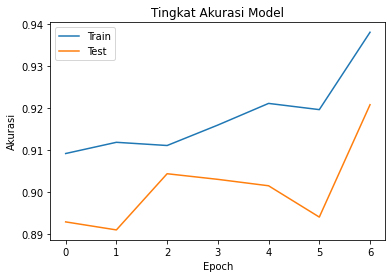

In [29]:
import matplotlib.pyplot as plt
# Melihat Tingkat Akurasi Model
plt.plot(history.history['accuracy'])    # Plotting learning(model fit) history untuk akurasi
plt.plot(history.history['val_accuracy'])# Plotting learning(model fit) history untuk validation akurasi
plt.title('Tingkat Akurasi Model')        # Set Judul Gambar
plt.ylabel('Akurasi')                     # Set Label y-axis
plt.xlabel('Epoch')                       # Set Label x-axis
plt.legend(['Train', 'Test'], loc='upper left') #memberikan legend Gambar untuk memudahkan membaca
plt.show()

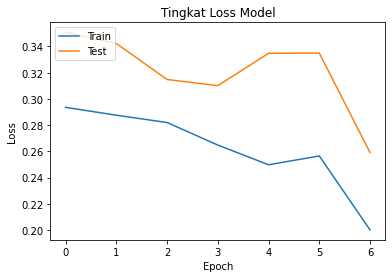

In [30]:
# # Melihat Tingkat Loss Model
plt.plot(history.history['loss'])     # Plotting learning(model fit) history untuk Loss
plt.plot(history.history['val_loss']) # Plotting learning(model fit) history untuk validation Loss
plt.title('Tingkat Loss Model')       # Set Judul Gambar
plt.ylabel('Loss')                        # Set Label y-axis
plt.xlabel('Epoch')                       # Set Label x-axis
plt.legend(['Train', 'Test'], loc='upper left') #memberikan legend Gambar untuk memudahkan membaca
plt.show()

Dari hasil evaluasi terlihat sedikit overfit, namun masih bisa di toleransi

# Save Model dan Convert Model


In [33]:
MODEL_NAME = 'Animal_Classification'
model.save(MODEL_NAME)


INFO:tensorflow:Assets written to: Animal_Classification/assets


INFO:tensorflow:Assets written to: Animal_Classification/assets


In [35]:
model.save('Animal_Classification.h5') 

In [44]:
# Convert model.
converter = tf.lite.TFLiteConverter.from_saved_model('/content/Animal_Classification')
tflite_model = converter.convert()

#Menyimpan Model.
with tf.io.gfile.GFile('/content/model.tflite', 'wb') as f:
  f.write(tflite_model)


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
